# Make each level to each Curve CSV FILE

In [1]:
%reset -f

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_begin = []
num_row = []
start = 0
number_of_corner =1
f_1 = 'beginner_expert_processedData/beginner/beginner_'
f_3 = '.csv'
num_begin = 25
curveList = [[103.9, 209.3], [316.6, 399.6], [425.3, 517.9], [590.5, 756.9], [1048.7, 1110.5], [1212.3, 1437.1]]

df_concat = pd.DataFrame()

for curve_num in range(start,number_of_corner):
#     print(num_row)
    for idx in range(1, num_begin+1):
        tmp_file = f_1+str(idx)+'_new2'+f_3
        df = pd.read_csv(tmp_file)
        df = df.dropna()
        
        tmp = df.astype(float)
        tmp['level'] =0
        
        tmpcorner = tmp[(tmp['Distance'] >= curveList[curve_num][0]) & (tmp['Distance'] <= curveList[curve_num][1])]
        num_row.append(np.size(tmpcorner,0)) 
        
        df_begin.append(tmpcorner)
        df_concat = pd.concat([df_concat,df_begin[idx-1]])      
           
    df_concat.to_csv('cornerData/corner_'+str(curve_num+1)+'_begin'+'.csv')
    df_concat = pd.DataFrame()
    df_begin = []
    


In [4]:
df_exp = []
f_1 = 'beginner_expert_processedData/expert/expert_'
f_3 = '.csv'
num_exp = 19

df_concat = pd.DataFrame()

for curve_num in range(start,number_of_corner):
    for idx in range(1, num_exp+1):
        tmp_file = f_1+str(idx)+'_new2'+f_3
        df = pd.read_csv(tmp_file)
        df = df.dropna()

        tmp = df.astype(float)
        tmp['level'] =1

        tmpcorner = tmp[(tmp['Distance'] >= curveList[curve_num][0]) & (tmp['Distance'] <= curveList[curve_num][1])]
        num_row.append(np.size(tmpcorner,0)) 

        df_exp.append(tmpcorner)
        df_concat = pd.concat([df_concat,df_exp[idx-1]])
    df_concat.to_csv('cornerData/corner_'+str(curve_num+1)+'_expert'+'.csv')
    df_concat = pd.DataFrame()
    df_exp = []

In [5]:
print(num_row)

[72, 71, 78, 91, 68, 69, 75, 84, 76, 79, 97, 102, 101, 89, 63, 74, 80, 69, 78, 88, 82, 75, 80, 78, 82, 68, 64, 64, 71, 68, 65, 66, 66, 67, 66, 72, 66, 67, 70, 68, 62, 68, 66, 72]


In [6]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import StandardScaler
# import time

left_column = [
#'Time',
    'Distance','GPS Latitude','GPS Longitude','Damper Velocity (Calc) FL','Damper Velocity (Calc) FR','Damper Velocity (Calc) RL',
'Damper Velocity (Calc) RR','Corr Dist','Corr Dist (Unstretched)','Corr Speed','Brake Pos',
'CG Accel Lateral','CG Accel Longitudinal','CG Accel Vertical','CG Height','Camber FL','Camber FR','Camber RL','Camber RR','Car Coord X',
'Car Coord Y','Car Coord Z','Car Pos Norm','Chassis Pitch Angle','Chassis Pitch Rate','Chassis Roll Angle','Chassis Roll Rate',
'Chassis Velocity X','Chassis Velocity Y','Chassis Velocity Z','Chassis Yaw Rate','Drive Train Speed','Engine RPM','Ground Speed',
'Ride Height FL','Ride Height FR','Ride Height RL','Ride Height RR','Road Temp','Self Align Torque FL','Self Align Torque FR',
'Self Align Torque RL','Self Align Torque RR','Session Time Left','Steering Angle','Suspension Travel FL','Suspension Travel FR',
'Suspension Travel RL','Suspension Travel RR','Tire Load FL','Tire Load FR','Tire Load RL','Tire Load RR','Tire Loaded Radius FL',
'Tire Loaded Radius FR','Tire Loaded Radius RL','Tire Loaded Radius RR','Tire Pressure FL','Tire Pressure FR','Tire Pressure RL','Tire Pressure RR',
'Tire Rubber Grip FL','Tire Rubber Grip FR','Tire Rubber Grip RL','Tire Rubber Grip RR','Tire Slip Angle FL','Tire Slip Angle FR',
'Tire Slip Angle RL','Tire Slip Angle RR','Tire Slip Ratio FL','Tire Slip Ratio FR','Tire Slip Ratio RL','Tire Slip Ratio RR',
'Tire Temp Core FL','Tire Temp Core FR','Tire Temp Core RL','Tire Temp Core RR','Tire Temp Inner FL','Tire Temp Inner FR',
'Tire Temp Inner RL','Tire Temp Inner RR','Tire Temp Middle FL','Tire Temp Middle FR','Tire Temp Middle RL',
'Tire Temp Middle RR','Tire Temp Outer FL','Tire Temp Outer FR','Tire Temp Outer RL','Tire Temp Outer RR','Toe In FL',
'Toe In FR','Toe In RL','Toe In RR','Wheel Angular Speed FL','Wheel Angular Speed FR','Wheel Angular Speed RL','Wheel Angular Speed RR',
'CG Distance','Lateral Velocity','Longitudinal Velocity','Lateral Acceleration','Longitudinal Acceleration','level']


#Hyper-parameters
num_epochs = 250
batches = 10
learning_rate = 0.003
input_size = len(left_column)-1 # left column except 'level'
output_size = 2 # Expert and Beginner
hidden_size = 10 # ?
num_layers = 2
num_begin_train = round(num_begin*0.75)*(number_of_corner-start)
num_exp_train = round(num_exp*0.75)*(number_of_corner-start)
num_begin_test = num_begin*(number_of_corner-start) - num_begin_train
num_exp_test = num_exp*(number_of_corner-start) - num_exp_train

print(num_begin_train, num_exp_train,num_begin_test,num_exp_test)
aug = 1
## Define GRU, Loss func and Optimizer
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layer, output_size):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
#         out, _ = self.lstm(x, (h0,c0)) 
        out = out[:, -1, :]
        out = self.fc(out)
        return out

gru = GRU(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(gru.parameters(), lr=learning_rate)  

gru.fc.weight.data.fill_(1)
gru.fc.bias.data.fill_(1)
print(gru.fc.weight,gru.fc.bias)

## Data Processing
array_x = []
array_y = []
input_x = []
input_y = []
n_row = []

df_tmp_begin = pd.DataFrame() 
df_tmp_exp = pd.DataFrame() 
for curve_num in range(start,number_of_corner):
    df_tmp_begin = pd.concat([df_tmp_begin,pd.read_csv('cornerData/corner_'+str(curve_num+1)+'_begin.csv')])
    df_tmp_exp   = pd.concat([df_tmp_exp,pd.read_csv('cornerData/corner_'+str(curve_num+1)+'_expert.csv')])    
df_curve1 = pd.concat([df_tmp_begin, df_tmp_exp], ignore_index=True) 
df_curve1 = df_curve1.loc[:,left_column]
df_curve1_saved = df_curve1.loc[:,left_column] # data backup
df_curve1.to_csv('cornerData/corner_'+'_dfcurve1'+'.csv')



# scaler = StandardScaler()
# scaler.fit(x)
# scaler.mean_
# x = scaler.transform(x)
# print(x_normal)
# # print(x)
# # print(x['Distance'])
# print(type(x))
# print(type(x_normal))

datum = df_curve1_saved
yyy = datum.pop('level')
left = left_column.remove('level')
for i in range(0,num_begin*(number_of_corner-start) + num_exp*(number_of_corner-start)):
#     x = df_curve1_saved.loc[0:num_row[i]-1
    y = yyy.loc[0:num_row[i]-1]
    x_original = datum.loc[0:num_row[i]-1]
    scaler = StandardScaler()
    scaler.fit(x_original)
    scaler.mean_
    x_normal = scaler.transform(x_original)
    x = pd.DataFrame(x_normal,columns=left)
#     print(datum)
#     print(i)
#     print(num_row)
#     print(num_row[i])
    datum.drop(range(0,num_row[i]),inplace=True)
    datum.reset_index(drop=True, inplace=True)
    yyy.drop(range(0,num_row[i]),inplace=True)
    yyy.reset_index(drop=True, inplace=True)
    # y = x.pop('level')
    
#     # DATA Augmentation
#     nan = pd.DataFrame(np.nan,columns=range(x.shape[1]),index=range(x.shape[0]))
#     alter = pd.concat([x,nan]).sort_index()
#     alter = alter.interpolate()
#     alter.reset_index(drop=True, inplace=True)
#     x_aug = alter[alter.index%2==1]

    
    array_x.append(x)
#     array_x.append(x_aug)
    array_y.append(y)
#     array_y.append(y)

    
## Randomize sequence 
sequence = np.arange((num_begin*(number_of_corner-start) + num_exp*(number_of_corner-start))*aug)
np.random.seed(10)
np.random.shuffle(sequence)

# sequence = [0,1,2,15,4,5,6,7,8,9,18,11,12,13,14,19,20,21,34,23,24,25,26,27,28,37,30,31,32,33,3,16,17,10,22,35,36,29]
print(sequence)

# # Data Augmentation
# num_row = pd.Series(num_row)
# num_row = num_row.repeat(2)
# # sequence = pd.Series(sequence)
# # sequence = sequence.repeat(2)
# num_row.reset_index(drop=True, inplace=True)
# # sequence.reset_index(drop=True, inplace=True)
# print(num_row, sequence)

for i in sequence:
    input_x.append(array_x[i])
    input_y.append(array_y[i])
    n_row.append(num_row[i])




## Train 
loss_list = []
iteration_list = []
accuracy_list = []
test_list=[]
count = 0
# torch.backends.cudnn.benchmark = True
print((num_begin_train + num_exp_train)*aug)

# start = time.time()  # 시작 시간 저장

for epoch in range(num_epochs):
    for i in range(0,(num_begin_train + num_exp_train)*aug):
        
#         print(i)
#         print(len(input_x))
        # array type (numpy) 앞
        X = np.array(input_x[i])
        X = X.reshape(-1,n_row[i],input_size)
        Y = np.array(input_y[i])   
        
        # tensor type (pytorch)
        X = torch.from_numpy(X)
        X = X.float()
        Y = torch.tensor([Y[0]])
        Y = Y.type(torch.LongTensor)
#         Y = Y.float()
        
        optimizer.zero_grad()
        output = gru(X)
        loss = criterion(output, Y)
        
        # Backward and optimize
#         optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         count += 1
#         loss_list.append(loss.data)
#         iteration_list.append(count)
#         accuracy_list.append(accuracy)
#         print (f'Loss: {loss.item():.4f}')
    count += 1
    loss_list.append(loss.data)
    iteration_list.append(count)
    print (f'Epoch: [{epoch}/num_epochs]' f'Loss: {loss.item():.4f}')
## Test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for i in range((num_begin_train + num_exp_train)*aug, (num_begin*(number_of_corner-start) + num_exp*(number_of_corner-start))*aug):
        
        # array type (numpy)
        print(i)
        X = np.array(input_x[i])
        X = X.reshape(-1,n_row[i],input_size)
        Y = np.array(input_y[i])   

        # tensor type (pytorch)
        X = torch.from_numpy(X)
        X = X.float()
        Y = torch.tensor([Y[0]])
        Y = Y.type(torch.LongTensor)
#         Y = Y.float()
        output = gru(X)
        _, predicted = torch.max(output.data, 1)
        n_samples += Y.size(0)
        n_correct += (predicted == Y).sum().item()
        print(Y, predicted)
        


    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the {(num_begin_test + num_exp_test)*aug} test images: {acc} %')
#     print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간



19 14 6 5
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True) Parameter containing:
tensor([1., 1.], requires_grad=True)
[26 10 27 39  3 33  7 18  2 23 32 38 30 34  6 12 21 20  5 13 19 17 14 31
 35  1 42 24 22 11 41  4 16 40 43  8 37 29 25 28  0 15 36  9]
33
Epoch: [0/num_epochs]Loss: 0.6731
Epoch: [1/num_epochs]Loss: 0.6523
Epoch: [2/num_epochs]Loss: 0.6337
Epoch: [3/num_epochs]Loss: 0.6169
Epoch: [4/num_epochs]Loss: 0.6018
Epoch: [5/num_epochs]Loss: 0.5880
Epoch: [6/num_epochs]Loss: 0.5756
Epoch: [7/num_epochs]Loss: 0.5642
Epoch: [8/num_epochs]Loss: 0.5537
Epoch: [9/num_epochs]Loss: 0.5442
Epoch: [10/num_epochs]Loss: 0.5354
Epoch: [11/num_epochs]Loss: 0.5272
Epoch: [12/num_epochs]Loss: 0.5197
Epoch: [13/num_epochs]Loss: 0.5126
Epoch: [14/num_epochs]Loss: 0.5058
Epoch: [15/num_epochs]Loss: 0.4994
Epoch: [16/num_epochs]Loss: 0.4930
Epoch: [17/num_epochs]Loss: 0.4867
Epoch: [18/num_epochs]Loss: 0.

Epoch: [221/num_epochs]Loss: 0.0041
Epoch: [222/num_epochs]Loss: 0.0041
Epoch: [223/num_epochs]Loss: 0.0041
Epoch: [224/num_epochs]Loss: 0.0041
Epoch: [225/num_epochs]Loss: 0.0040
Epoch: [226/num_epochs]Loss: 0.0040
Epoch: [227/num_epochs]Loss: 0.0040
Epoch: [228/num_epochs]Loss: 0.0040
Epoch: [229/num_epochs]Loss: 0.0039
Epoch: [230/num_epochs]Loss: 0.0039
Epoch: [231/num_epochs]Loss: 0.0039
Epoch: [232/num_epochs]Loss: 0.0039
Epoch: [233/num_epochs]Loss: 0.0038
Epoch: [234/num_epochs]Loss: 0.0038
Epoch: [235/num_epochs]Loss: 0.0038
Epoch: [236/num_epochs]Loss: 0.0038
Epoch: [237/num_epochs]Loss: 0.0037
Epoch: [238/num_epochs]Loss: 0.0037
Epoch: [239/num_epochs]Loss: 0.0037
Epoch: [240/num_epochs]Loss: 0.0037
Epoch: [241/num_epochs]Loss: 0.0036
Epoch: [242/num_epochs]Loss: 0.0036
Epoch: [243/num_epochs]Loss: 0.0036
Epoch: [244/num_epochs]Loss: 0.0036
Epoch: [245/num_epochs]Loss: 0.0036
Epoch: [246/num_epochs]Loss: 0.0035
Epoch: [247/num_epochs]Loss: 0.0035
Epoch: [248/num_epochs]Loss:

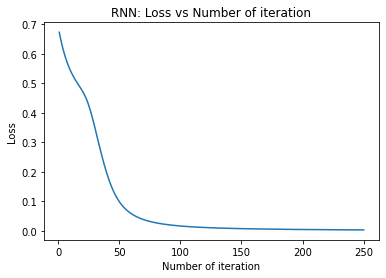

Accuracy of the network on the 11 test images: 81.81818181818181 %
tensor([0]) tensor([0]) tensor([[8.5634, 2.1933]])


In [7]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()
print(f'Accuracy of the network on the {num_begin_test + num_exp_test} test images: {acc} %')
print(predicted, Y, output)
# print(iteration_list)
# # visualization accuracy 
# plt.plot(iteration_list,accuracy_list,color = "red")
# plt.xlabel("Number of iteration")
# plt.ylabel("Accuracy")
# plt.title("RNN: Accuracy vs Number of iteration")
# plt.savefig('graph.png')
# plt.show()

In [8]:
food = 'bread'
vars()['cat'] = 123
print(cat)
print(type(cat))

123
<class 'int'>


In [9]:
a = pd.DataFrame() 
print(a)

Empty DataFrame
Columns: []
Index: []


In [10]:
s = pd.Series([0, 1, np.nan, 10])
s.interpolate()

0     0.0
1     1.0
2     5.5
3    10.0
dtype: float64

In [11]:
print(food)

bread


In [12]:
# print(x)
x.shape
nan = pd.DataFrame(np.nan,columns=range(x.shape[1]),index=range(x.shape[0]))
alter = pd.concat([x,nan]).sort_index()
alter = alter.interpolate()
alter.reset_index(drop=True, inplace=True)
print(alter[alter.index%2==0])
print(alter[alter.index%2==1])


          0         1         2         3         4         5         6    \
0   -1.939161  2.419064 -1.456527 -2.844837 -0.616704  0.059867  1.066608   
2   -1.862023  2.298240 -1.427066  1.342429  0.564276 -1.030766 -1.424866   
4   -1.788239  2.187168 -1.399030  0.411926  0.917171  0.798914 -0.055242   
6   -1.717808  2.065260 -1.367193  1.350688  0.399389  0.603269  1.660401   
8   -1.644024  1.953105 -1.335831 -1.460093 -0.915447  0.373184  0.221428   
..        ...       ...       ...       ...       ...       ...       ...   
134  1.414660 -0.792619  1.631987  0.626963  0.902568 -0.676310 -0.123867   
136  1.449875 -0.773294  1.678238  0.398620  0.198605  0.140468  0.426222   
138  1.491798 -0.748100  1.732884 -0.419012 -0.400403  0.615706  1.008457   
140  1.532044 -0.721822  1.784916 -0.807181 -0.473112  0.426998  0.497737   
142  1.592413 -0.681186  1.859282 -0.098291  0.092736 -0.429005 -0.240170   

          7         8         9    ...       92        93        94   \
0  

In [13]:
from sklearn.preprocessing import StandardScaler
print(x['Distance'])
scaler = StandardScaler()
print(scaler.fit(x))
print(scaler.mean_)
# print(scaler.transform(x))
x_normal = scaler.transform(x)
print(x_normal)
# print(x)
# print(x['Distance'])
print(type(x))
print(type(x_normal))

KeyError: 'Distance'

In [ ]:
# %reset -f
print(gru.fc.weight,gru.fc.bias)

In [ ]:
import pandas
a = np.array([1,2,3])
a = pd.DataFrame([1,2,3])
print(a)
# a.repeat(2)
# np.array(num_row).repeat(2)
# num_row = pd.Series(num_row)
# num_row.repeat(2)
print(num_row)
type(num_row)
abc = pd.Series(num_row)
abc.repeat(2)

In [ ]:
num_begin_train = round(num_begin*0.75)*(number_of_corner-start)
num_exp_train = round(num_exp*0.75)*(number_of_corner-start)
num_begin_test = num_begin*(number_of_corner-start) - num_begin_train
num_exp_test = num_exp*(number_of_corner-start) - num_exp_train
# print(num_begin_train, num_exp_train,num_begin_test,num_exp_test)
num_begin_train